# Neural Network from Scratch (Using NumPy)

Hello! I am Daniel Lim, and this is a notebook written to test out the neural network I
wrote using only `NumPy`.

For this personal project, I wanted to test the Neural Net's performance on a simple,
nonlinearly separable binary classification problem. As such, I went to kaggle and retrieved a
dataset for a Binary Classification Problem, the [Diabetes
Dataset](https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database?resource=download).




## Notebook Setup: Imports + Reading Data

In [1]:
# %load_ext autoreload
# %autoreload 2
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import numpy as np
import logging
from src.nn_clf import NeuralNetworkClassifier
import omegaconf
import matplotlib.pyplot as plt

logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.INFO)
logger = logging.getLogger()


In [2]:
df = pd.read_csv('data/diabetes.csv')
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


## 1. Quick Exploratory Data Analysis

As the focus of this personal project is on the implementation of the Neural Network
from scratch, I will not be spending too much time on the EDA of the dataset as the
model performance is not as important to me. I will just do
some basic checks.

In [3]:
df.dtypes

Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object

Great, they're all numerical data. No need to do ordinal / categorical encoding.

In [4]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


Across the board, **no missing values**, great. `Outcome` is the label to train the
model on, so I'll separate it as `y` later. Let's check the balance in the labels next.

In [5]:
df['Outcome'].value_counts()

Outcome
0    500
1    268
Name: count, dtype: int64

Pretty imbalanced dataset. Better do some stratification during the train-test
splitting. This also means **Accuracy** shouldn't be the main evaluation metric.
Rather, F1-Score, or Recall should be used as they better represent model performance on
imbalanced datasets. Maybe even ROC-AUC.

Alright, next I'll do a train-test split, scale the data, and train the model.

## 2. Data Preprocessing

#### Train Test Split

I will not split the data into a validation set, opting just for a simple Train and Test
split. I'll use a 70 / 30 split.

In [6]:
train_data, test_data = train_test_split(df, test_size=0.3, random_state=42, stratify=df['Outcome'])

X_train = train_data.drop(columns=['Outcome'])
y_train = train_data['Outcome']

X_test = test_data.drop(columns=['Outcome'])
y_test = test_data['Outcome']

#### Scaling the input data

As we are training a Neural Network, the convergence of the model on minimas is highly
influenced by the scale of the features since the gradients can be disproportionately
large or small, and activation functions might also be affected by the scale of
features.

Some form of scaling applied to the data will help with this, as it leads to more
uniform and stable gradients. I chose standard scaling as it is robust to outliers,
though not much thought went into this choice since the goal is to implement the NN.

The scaler is fit on the training data and transforms both train and test data. The
scaler should not be fit on the test data as that would be data leakage.

In [7]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#### Creating `train_dataset` and `val_dataset` Tuples

I wrote the model to take in tuples for the training loop, to sort of simulate a PyTorch
dataset / dataloader, where the training loop just unpacks the tuples of inputs and
outputs. 

Because of this, we have to put the input and labels as numpy arrays into a tuple each.
Also take note that the matching of the labels to the inputs is essential at this point,
but since I didn't do any shuffling, only scaling, this shouldn't be a problem.

In [8]:
y_train = y_train.to_numpy().reshape(-1, 1)
y_test = y_test.to_numpy().reshape(-1, 1)

In [9]:
train_data = (X_train, y_train)
test_data = (X_test, y_test)

## 3. Model Instantiation

I have written the model to take in an OmegaConf DictConfig, located in
`conf/nn_config.yaml` as it makes the model instantiation simpler in this
notebook and it also contains all the configurations in a YAML file, easy to configure.

In [10]:
params = omegaconf.OmegaConf.load('conf/nn_config.yaml')
model_params = params["model"]
print(model_params)

{'hidden_layer_sizes': 16, 'batch_size': 32, 'learning_rate': 0.0001, 'max_iter': 300, 'random_state': 42, 'momentum': 0.9, 'input_size': 8, 'output_size': 1, 'dropout': 0.01}


Now, to instantiate the model. I have set the logging level to `INFO` in the first cell,
but if you want to see all the `DEBUG` level information, you may set it there, that
would give a lot more insight into the inner workings of the model as you interface with
it.

I have also written a `__str__` and `__repr__` method to output a string representation
of the model to *kind of* show that the model was instantiated properly.

In [11]:
model = NeuralNetworkClassifier(model_params)
model

NeuralNetworkClassifier(
  Input Layer: 8 -> 16
  Hidden Layer 1: 16 -> 16
  Hidden Layer 2: 16 -> 16
  Hidden Layer 3: 16 -> 16 (with Residual Connection from Hidden Layer 1)
  Hidden Layer 4: 16 -> 16
  Output Layer: 16 -> 1
  Dropout Probability: 0.01
  Learning Rate: 0.0001
  Momentum: 0.9
  Max Iterations: 300
  Batch Size: 32
  Random State: 42
)

## 4. Model Training

As I mentioned, the `fit()` method takes in tuples as arguments. In this case, I have
allowed the method to also take in a validation set to get validation losses while
training. Since I did not split the dataset into a validation set, I will pass the test
dataset in as a "validation" set to see the val losses over epochs. This will provide
insights to the model's learning over time.

In [12]:
model.fit(train_data, test_data)

  0%|          | 0/300 [00:00<?, ?it/s]INFO:Epoch 1 Training Loss:0.7657657568679859
INFO:Epoch 1 Validation Loss:0.7547036976452013
INFO:Epoch 2 Training Loss:0.7212552741945721
INFO:Epoch 2 Validation Loss:0.7086495797273206
INFO:Epoch 3 Training Loss:0.6871874899620325
INFO:Epoch 3 Validation Loss:0.6832140985079032
INFO:Epoch 4 Training Loss:0.6684255222635481
INFO:Epoch 4 Validation Loss:0.6700766223918159
INFO:Epoch 5 Training Loss:0.6568667656940931
INFO:Epoch 5 Validation Loss:0.6626739103727626
INFO:Epoch 6 Training Loss:0.650496872691043
INFO:Epoch 6 Validation Loss:0.6574294340508612
INFO:Epoch 7 Training Loss:0.6431512458105751
INFO:Epoch 7 Validation Loss:0.6534159627646056
INFO:Epoch 8 Training Loss:0.6382389015823894
INFO:Epoch 8 Validation Loss:0.6500045216914011
INFO:Epoch 9 Training Loss:0.636981832037099
INFO:Epoch 9 Validation Loss:0.6468270066815627
INFO:Epoch 10 Training Loss:0.6353181220390534
INFO:Epoch 10 Validation Loss:0.6438856116377064
INFO:Epoch 11 Trainin

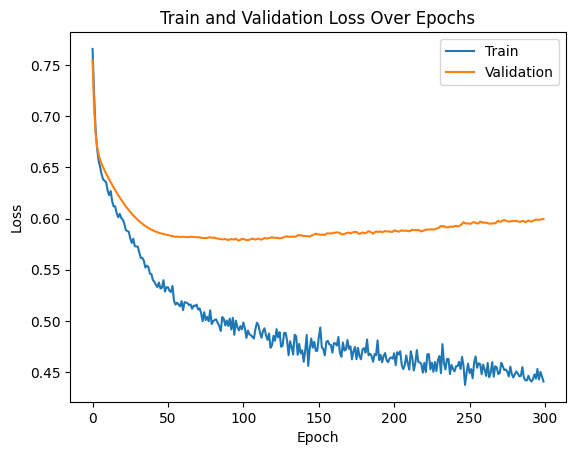

In [13]:
training_loss = model.epoch_losses
val_loss = model.val_losses
plt.plot(training_loss)
plt.plot(val_loss)
plt.title('Train and Validation Loss Over Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

#### Insights from Train and Validation Loss

First of all, we can see a decreasing trend for both train and validation losses, which
is a good thing. A decreasing training loss is an indicator that the model is learning,
so at least the model is implemented correctly.

However, the validation loss starts diverging from the train loss at around epoch 30,
and it starts rising instead, while the train loss still trends downward. This is a
classic indicator for overfitting, or a High Variance model. This could mean that the
model is learning the noise or specific patterns in the training data, and failing to
generalise to the validation data. In this case, the model might be too complex for the 

As the train loss is pretty low, or since it's still decreasing over epochs, we can say
that the model has a low bias.

In this case, it might be safe to say that we can afford lowering the complexity of the
model and see the effects it has on the losses and model performance. This might mean:
- Smaller number of hidden layers (Current: 4, with residual connections)
- Smaller number of hidden neurons (Current: 16 per hidden layer)

Regularisation could also be introduced:
- Dropout is already implemented, experiment with different values (Current: 1%)
- L2 Regularisation

However, I would actually suggest doing more EDA on the data, maybe doing some feature
engineering or getting more findings which could positively impact the model
performance. 

## 5. Model Evaluation

The performance of the model can also be evaluated on it's ability to classify the data
into either 0 (No diabetes) or 1 (Diabetes). As we have an imbalanced dataset of around
2:1 (Negatives to Positives), we should focus more on F1 or Recall.

Since this is a Healthcare Problem, and looking at the problem statement, it might be
better to focus on Recall, since we would rather have the model identify the most
positive cases at the cost of more false positives, as it would be relatively better to
misclassify someone to be at risk of having diabetes and have them live a healthier
life, than to misclassify someone as safe from diabetes when they are at risk of having
diabetes, which might exacerbate their condition.

In [14]:
y_preds = model.predict(X_test)
y_preds_binary = np.round(y_preds)
clf = classification_report(y_test, y_preds_binary)
print(clf)

              precision    recall  f1-score   support

           0       0.80      0.85      0.82       150
           1       0.68      0.60      0.64        81

    accuracy                           0.76       231
   macro avg       0.74      0.73      0.73       231
weighted avg       0.76      0.76      0.76       231



A recall of 0.60 on the positive class (diabetes) is not great, but keep in mind that this is a
very quick run through of a training pipeline, which is pretty decent. Just to round
things off, here's a confusion matrix of the predictions.

One thing about these classification models, is we can even consider tuning the
threshold we binarise our values at. Currently, we set it to just do a np.round(), but
we can even set it higher or lower, based on the probability threshold graphs.

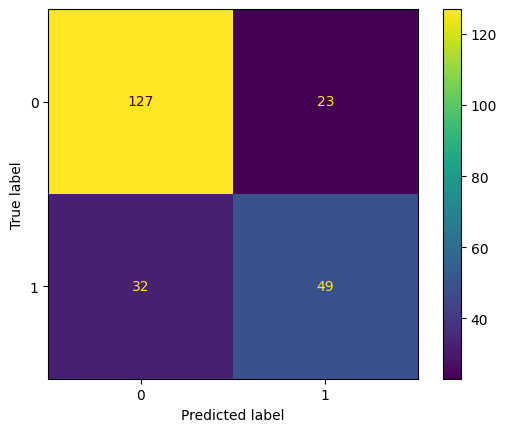

In [15]:
conf = confusion_matrix(y_test, y_preds_binary)
disp = ConfusionMatrixDisplay(confusion_matrix=conf, display_labels=[0, 1])
disp.plot()